# 1. The 20/3/2020 lockdown (MooJin)

In [ ]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as sc
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as date
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
%matplotlib inline 

In [ ]:
df1 = pd.read_csv('data/covid1.csv') # sourced from https://www.inspq.qc.ca/covid-19/donnees
df1.head()
df1 = df1.drop(columns=['Moyenne mobile (7 jours)', 'Annotations 1'])
df1.rename(columns = {'Date de résultat du test':'Date', 'Cas confirmés':'Confirmed Case'}, inplace = True)# Translate columns in English
df1.head()

,Date,Confirmed Case
0,2020-02-24 00:00:00,0
1,2020-02-25 00:00:00,0
2,2020-02-26 00:00:00,0
3,2020-02-27 00:00:00,0
4,2020-02-28 00:00:00,0


<AxesSubplot:>

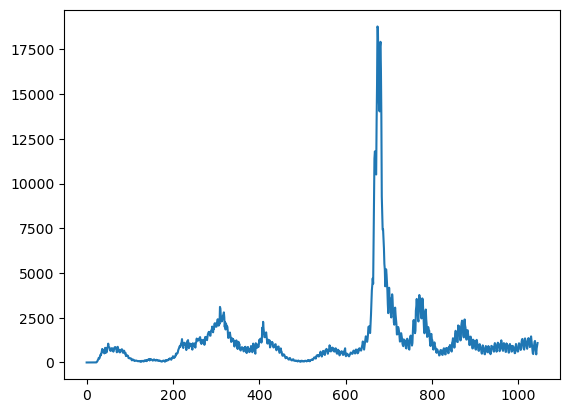

In [ ]:
df1['Confirmed Case'].plot()# quick overview of data

In [ ]:
# Convert date to datetime, set date as index
df1.Date = pd.to_datetime(df1.Date)
df1 = df1.set_index('Date')
df1.head(15)

,Confirmed Case
Date,
2020-02-24,0
2020-02-25,0
2020-02-26,0
2020-02-27,0
2020-02-28,0
2020-02-29,0
2020-03-01,0
2020-03-02,0
2020-03-03,0


In [ ]:
# check missing values
df1['Confirmed Case'].isna().sum()

0

In [ ]:
# to smoothen the data by using moving average per week
df1['moving_avg_week']=df1.rolling(window = 7, center=True).mean()['Confirmed Case']
df1.dropna(inplace=True)
df1.head()

,Confirmed Case,moving_avg_week
Date,,
2020-02-27,0,0.0
2020-02-28,0,0.0
2020-02-29,0,0.0
2020-03-01,0,0.0
2020-03-02,0,0.0


<AxesSubplot:xlabel='Date', ylabel='CASE'>

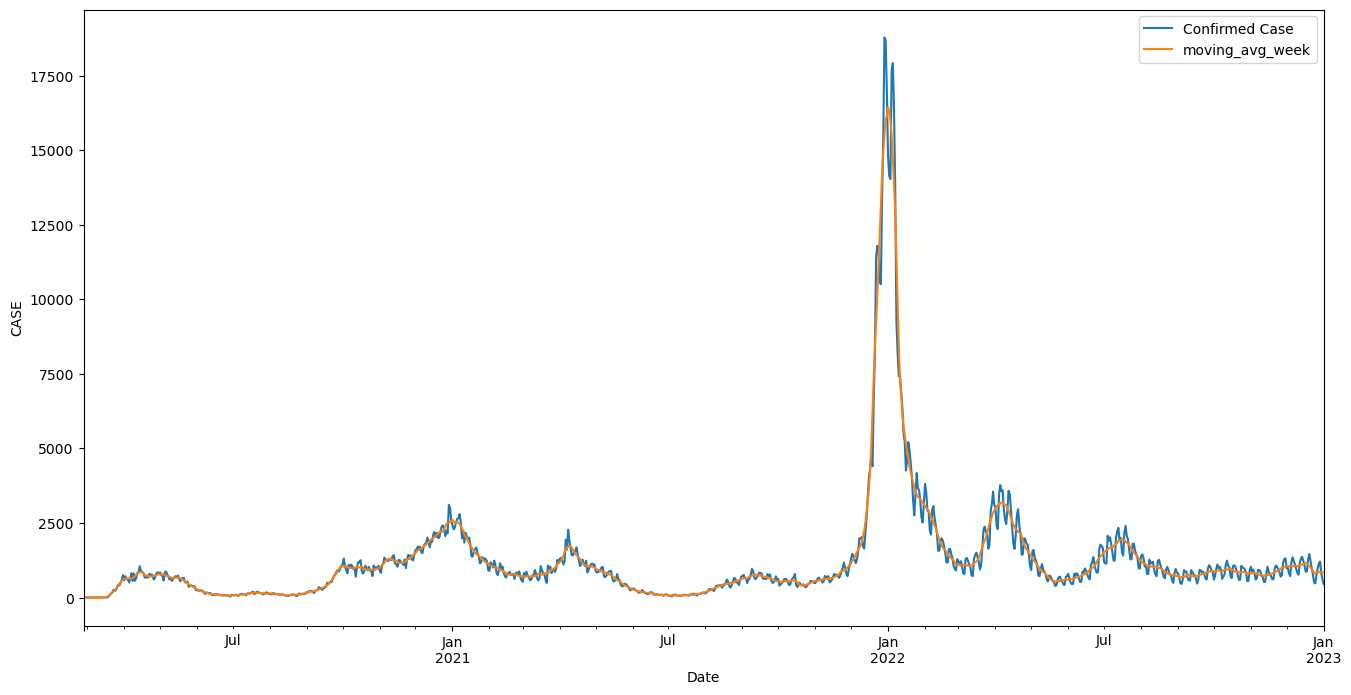

In [ ]:
# Visual check with both features case and moving avg
df1[['Confirmed Case', 'moving_avg_week']].plot(ylabel='CASE',figsize=(16, 8))

<AxesSubplot:xlabel='Date', ylabel='CASE'>

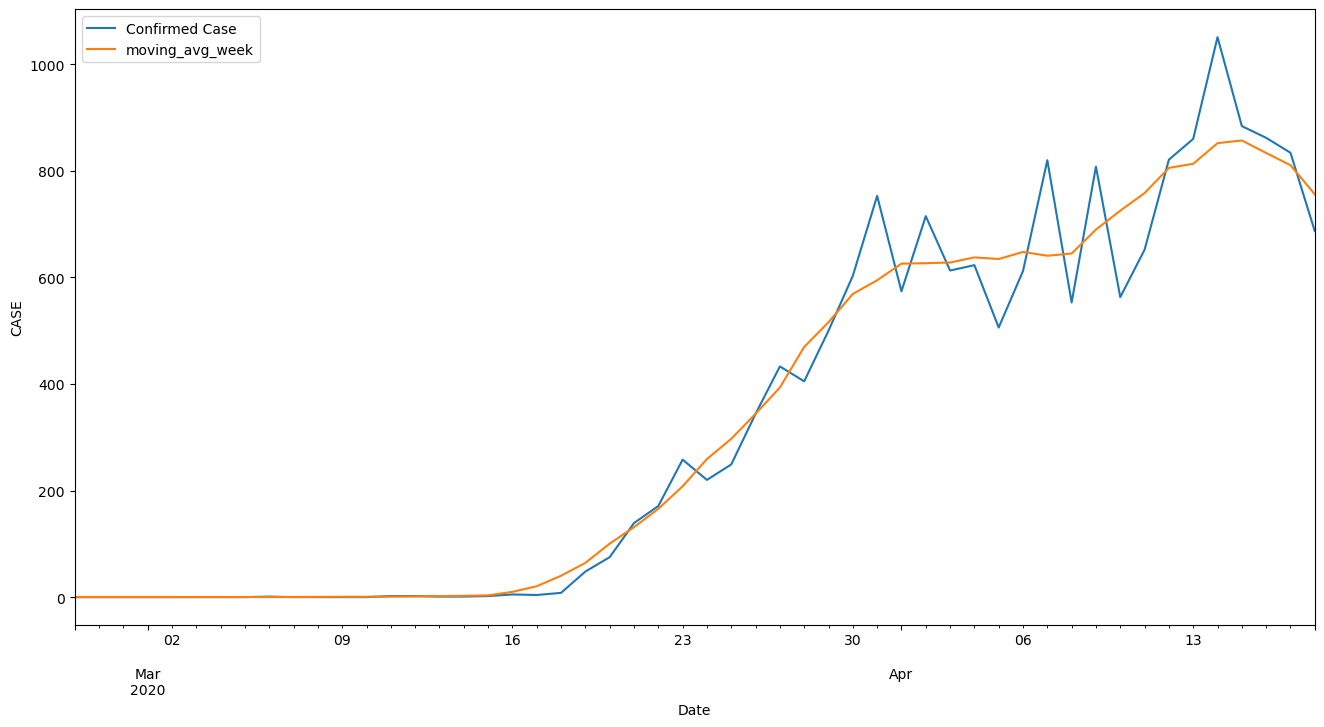

In [ ]:
#create lockdown date
lockdown1 = date.datetime(year=2020, month=3, day=20)
# select 60-day period, 30-day before & 30-day after, considering the 2-week covid period
df1_60days = df1.loc[(lockdown1 - date.timedelta(30) < df1.index) & (df1.index < lockdown1 + date.timedelta(30))]
df1_60days[['Confirmed Case', 'moving_avg_week']].plot(ylabel='CASE',figsize=(16, 8))


In [ ]:
# Split the data set into before and after event of interest
df1_60days['tally_day'] = [n for n in range(len(df1_60days))]
df1_before = df1_60days.loc[df1_60days.index < lockdown1]
df1_after = df1_60days.loc[df1_60days.index >= lockdown1]


/tmp/ipykernel_29656/2449410786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_60days['tally_day'] = [n for n in range(len(df1_60days))]


In [ ]:
df1_before
df1_before = df1_before[6:] # dropoff no-case days at the beginning
df1_before

,Confirmed Case,moving_avg_week,tally_day
Date,,,
2020-03-04,0,0.142857,6
2020-03-05,0,0.142857,7
2020-03-06,1,0.142857,8
2020-03-07,0,0.142857,9
2020-03-08,0,0.428571,10
2020-03-09,0,0.714286,11
2020-03-10,0,0.714286,12
2020-03-11,2,0.857143,13
2020-03-12,2,1.142857,14


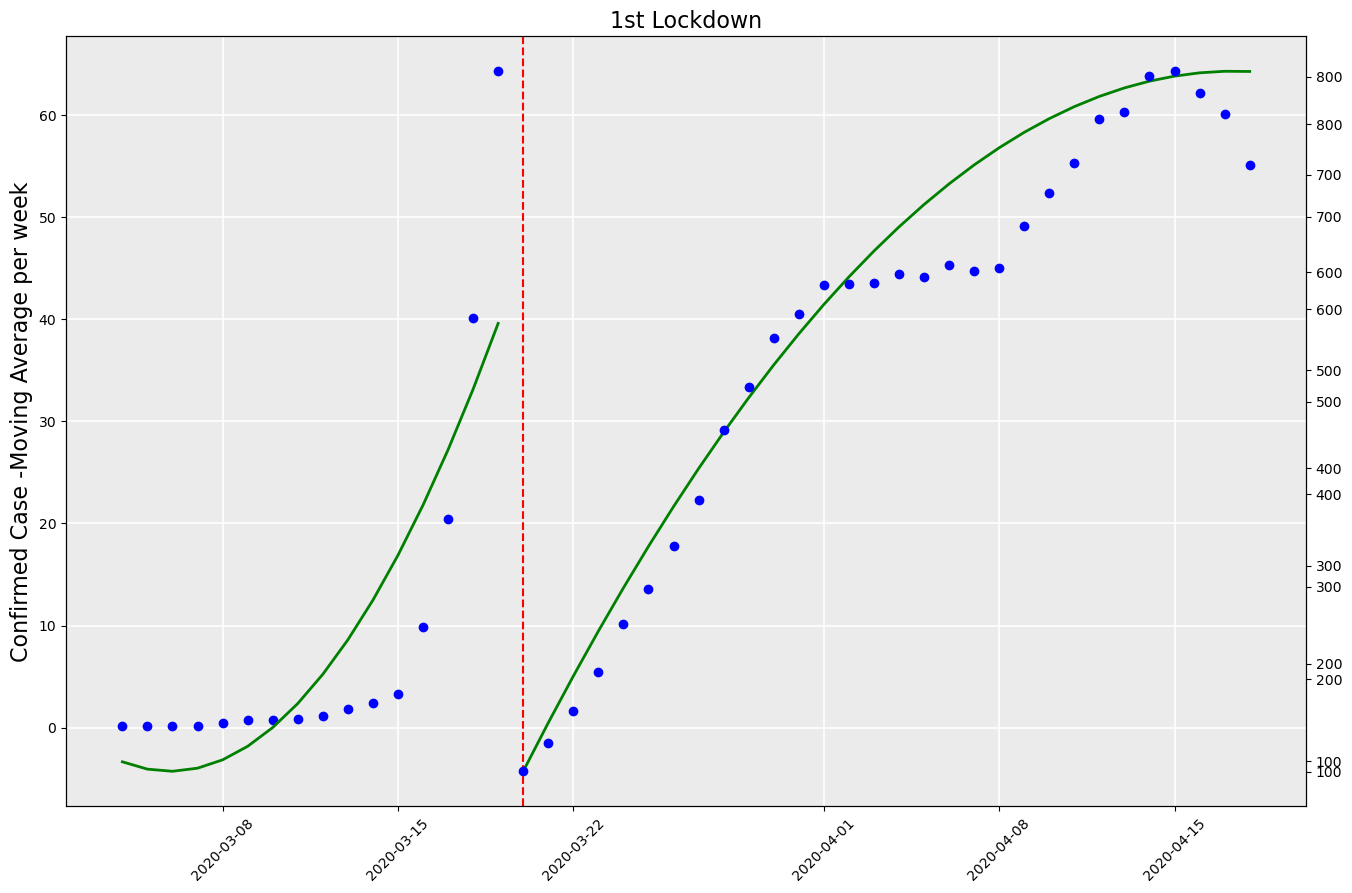

In [ ]:
# Create figure and designate the axes object
_, ax = plt.subplots(figsize=(16,10))
plt.xticks(rotation = 45)

# Fit et plot - BEFORE
X_before = df1_before.tally_day.values.reshape(-1, 1)
X_before = np.c_[X_before, X_before**2]
y_before = df1_before['moving_avg_week'].values.reshape(-1, 1)
# model_before = LinearRegression() # first regression model try-out 
model_before = Ridge(alpha=15) 
model_before.fit(X_before,y_before)

y_est_before = model_before.predict(X_before)
ax.plot(df1_before.index, y_est_before, c='g', lw=2)
ax.scatter(df1_before.index, df1_before.moving_avg_week, c='b')


# Fit et plot - AFTER

X_after = df1_after.tally_day.values.reshape(-1, 1)
y_after = df1_after['moving_avg_week'].values.reshape(-1, 1)
model_after = LinearRegression()
# tried higher ploy degrees, more than 2 deg became overfitting
X_after = np.c_[X_after, X_after**2]
model_after.fit(X_after,y_after)
y_est_after = model_after.predict(X_after)
ax.twinx().plot(df1_after.index, y_est_after, c='g', lw=2)
ax.twinx().scatter(df1_after.index, df1_after.moving_avg_week, c='b') 

ax.set_ylabel('Confirmed Case -Moving Average per week', size=16)
ax.set_title('1st Lockdown', size=16)
ax.axvline(lockdown1, ls='--', c='r')

# add some aesthetics in the plot
ax.set_axisbelow(True)
ax.set_facecolor('#EBEBEB')# Give plot a gray background 
[ax.spines[side].set_visible(False) for side in ax.spines]# Remove border around plot
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)





In [ ]:
# T-tests to see the statistical relation between 'before' et 'after'
# statistic indicates the sample mean of 'before'is less than the one of 'after'.
# P-value indicates one can reject the null hypothesis
print(sc.ttest_ind(df1_before['Confirmed Case'], df1_after['Confirmed Case']))


Ttest_indResult(statistic=-8.941562181069, pvalue=1.8720622099396845e-11)


### Requirements

#### 1. An interpretation of the p-value on the effect of the measure taken (the cutoff parameter)
   See above


#### 2. An interpretation of the p-value on the effect of the measure taken (the cutoff parameter)

   T-tests to see the statistical relation between 'before' et 'after'
statistic indicates the sample mean of 'before'is less than the one of 'after'. the P-value tests the null hypothesis(independent variable does not have correlation with prediected variable).With low p-value less than 0.05, one can reject it. In other words, a feature with low p-value is likely to influence its predicted value as seen below.

    statistic=-8.941562181069, pvalue=1.8720622099396845e-11
    
#### 3. A justification on the design of your regression:

   I have selected the 8-week period equally divided before and after the cutoff, the beginning of lockdown. Considering a 2-week incubation period of COVID, it is sensible to capture the data that might have possibly been caused by the lockdown.
   
   The objective is to depict the data while avoiding unnecessary complexity, namely overfitting. Since we are dealing with the data retrospectively rather than predicting, I approached it with the brute force method, trial and error. Plotting and statistical summaries such as R-squared values helped me to choose the degree of polynomial in regression analysis.In this case, any higher than 2 degree is not worth the complexity it creates. 

   I have considered other regression analyses that were introduced during the lecture. Considering the data type, continuous data, I opted out of some like logistic regression(for classification dataset). I weighed between linear and ridge regression. I concluded the linear regression equipped with polynomical features did the job. 

#### 4.  Thoughts on findings

   Based on the visualization and statistical summary, I can deduce there is a strong correlation between two different periods marked by the treatment, the lockdown. Here, I used the tallied day(running variable) while COVID-19 spreaded across QC. The confirmed case is dependent variable in the form of the moving average that enables us to see the smoothen data pattern. Here, we can see the treatment effect known as 'flattenening the curve'. Hereby, can I say there is causal relationship?
   
   Causal relationship does not necessarily mean correlation there, and vice versa. To ensure the causal relationship, one should ideally have a Randomized Clinical Trial(RCT) as in the new medecine trial. However, I can deduce that no other major factors were present during the first lockdown period. In addition via Observational tudies(OS) as seen in many other countries, I can safely claim that the lockdown slowed down the propagation of COVID-19. 




# 2. The reopening of schools on 31/8/2020 (René)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
%matplotlib inline

In [2]:
df = pd.read_csv("../data/COVID19_Qc.csv")
df.drop(0, axis=0, inplace=True)
df.reset_index(inplace=True)
df = df[['Date','Nb_Nvx_Cas']]
df.reset_index(drop=False, inplace=True)
df = df.rename(columns={'Nb_Nvx_Cas': 'cases'})
df.Date = pd.to_datetime(df.Date)

In [3]:
days = 47 # perfect for a "good" rsqur on both models

cutoff_date = pd.to_datetime("2020/8/31", format="%Y/%m/%d") # the reopening of schools
df["treatment"] = df.Date.apply(lambda x: 1 if x >= cutoff_date else 0) # boolean
control_group = df[df.Date < cutoff_date].iloc[-days:,:] # group before reopening
treatment_group = df[df.Date >= cutoff_date].iloc[:days,:] # group after reopening

<AxesSubplot: xlabel='Date', ylabel='cases'>

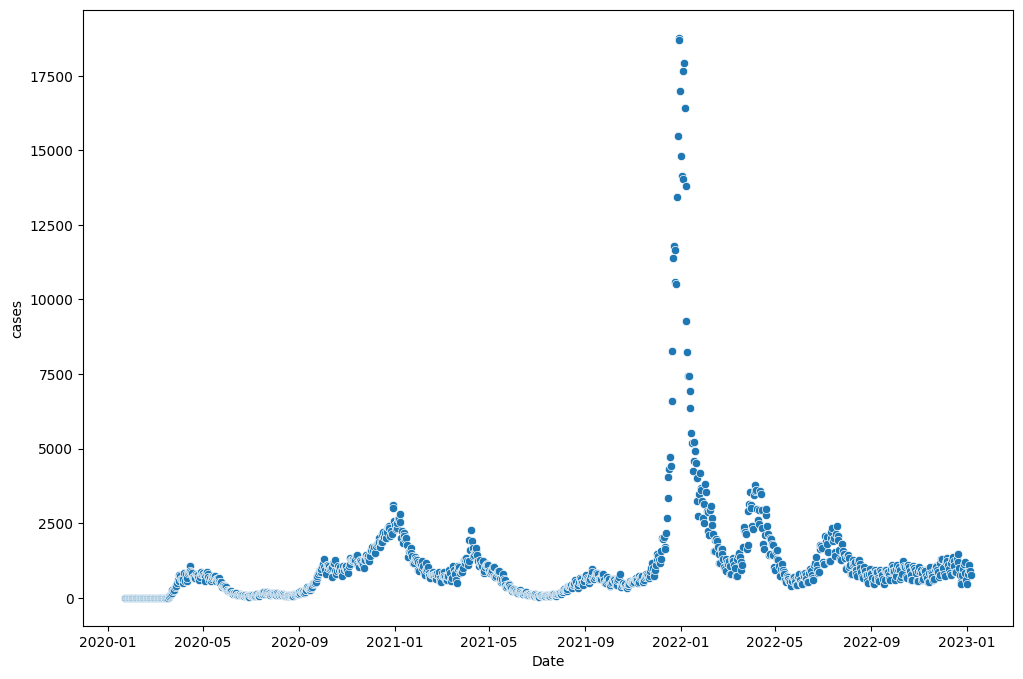

In [4]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.scatterplot(x=df.Date, y=df.cases)

In [5]:
# control model
control_X = control_group["index"]
control_X = sm.add_constant(control_X)
control_y = control_group.cases.values

control_model = sm.OLS(control_y, control_X).fit()

# treatment model
treatment_X = treatment_group["index"]
treatment_X = sm.add_constant(treatment_X)
treatment_y = treatment_group.cases.values

treatment_model = sm.OLS(treatment_y, treatment_X).fit()

In [6]:
print(control_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     30.44
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           1.62e-06
Time:                        20:29:10   Log-Likelihood:                -224.37
No. Observations:                  47   AIC:                             452.7
Df Residuals:                      45   BIC:                             456.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        460.6835     62.160      7.411      0.0

In [7]:
print(treatment_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     286.7
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           3.83e-21
Time:                        20:29:11   Log-Likelihood:                -297.93
No. Observations:                  47   AIC:                             599.9
Df Residuals:                      45   BIC:                             603.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5571.8414    367.964    -15.142      0.0

<AxesSubplot: xlabel='index'>

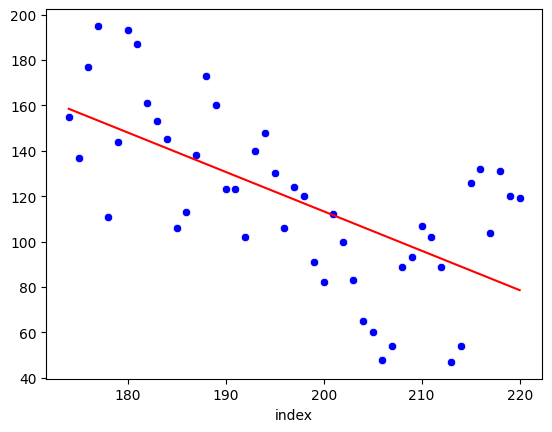

In [8]:
# this plot shows a downtrend happening before the oppening of schools
control_pred = control_model.predict(control_X)

sns.scatterplot(x=control_X["index"], y=control_y, color="blue")
sns.lineplot(x=control_X["index"], y=control_pred, color="red")

<AxesSubplot: xlabel='index'>

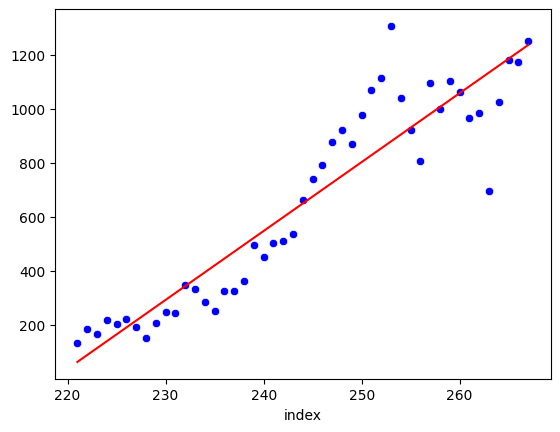

In [9]:
# this plot shows an uptrend happening after the oppening of schools
treatment_pred = treatment_model.predict(treatment_X)

sns.scatterplot(x=treatment_X["index"], y=treatment_y, color="blue")
sns.lineplot(x=treatment_X["index"], y=treatment_pred, color="red")

<AxesSubplot: title={'center': 'New covid cases by day'}, xlabel='Days', ylabel='New covid cases'>

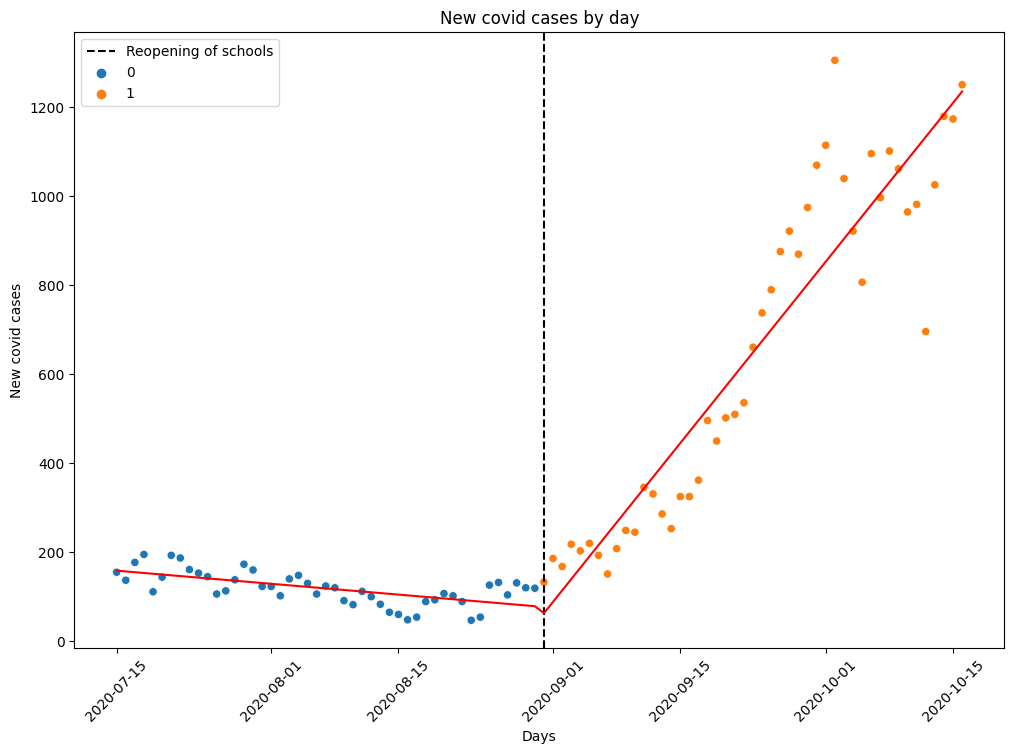

In [10]:
plt.figure(figsize=(12,8))
plt.xticks(rotation=45, )
plt.axvline(cutoff_date, c="black", ls="--", label="Reopening of schools")
plt.xlabel("Days")
plt.ylabel("New covid cases")
plt.title("New covid cases by day")

# simplify the plot
the_event = pd.concat([control_group, treatment_group])
date_list = the_event.Date.to_list()
concat_pred = pd.concat([control_pred, treatment_pred])
sns.scatterplot(data=the_event, x=date_list, y=the_event.cases.values, hue=the_event.treatment)
sns.lineplot(x=date_list, y=concat_pred, color="red")

# sns.scatterplot(x=control_X["index"], y=control_y)
# sns.scatterplot(x=treatment_X["index"], y=treatment_y)
# sns.lineplot(x=control_X["index"], y=control_pred, color="red")
# sns.lineplot(x=treatment_X["index"], y=treatment_pred, color="red")

### An interpretation of the p-value on the effect of the measure taken (the cutoff parameter)
-Low p-values here (both virtually 0.000) indicates strong evidence against the null hypothesis, and suggests that the independent variable is a statistically significant predictor of the dependent variable.
### A justification on the design of your regression:
### The amount of time included on both sides of the cutoff (longer is not necessarily better)
- Being guided by known medical facts about Covid (incubation period, asymptomatic cases, transmition rate etc), I started at 20 days which resulted in poor models.
- Playing around a bit with the numbers, I found that both models' rsquared metric would peak at 47 then drop if pushed too much past that mark.
- So 47 was chosen.
### The polynomial degree (higher is not always better)
- After reading and experimenting a bit, I decided to go against polynomials. The general idea is well captured with a simple model of linear regression.
- Having the regression line curve and follow the scatter plot more closely with polynomials (overfitting) would take away from the simplicity and wouldnt add anything of value.
### Other regression design considerations
- Trying to fit a single model with a single line was "ugly" and did not help to understand the situation.

### A 2 paragraph explanation of your findings for that event

In [11]:
print("""
From what I can tell, following a major lockdown due to an increasing number of Covid cases and a strain on the healthcare system, 
the daily new cases were dropping at a consistent rate, as shown on the left side of the graph. 
This suggested that things were "under control." 
However, as a result, a date was decided for the reopening of schools on August 31st, 2020, which served as our "cutoff."

Two weeks prior to the reopening of schools, the number of daily new cases began to rise. 
This may have been caused by people going out more in anticipation of the school reopening and thinking it was "safer." 
Unfortunately, this turned out to be just the beginning. 
The number of daily new cases peaked at 1,300, marking the first plateau in a series of peaks and plateaus in the coming months.
""")


From what I can tell, following a major lockdown due to an increasing number of Covid cases and a strain on the healthcare system, 
the daily new cases were dropping at a consistent rate, as shown on the left side of the graph. 
This suggested that things were "under control." 
However, as a result, a date was decided for the reopening of schools on August 31st, 2020, which served as our "cutoff."

Two weeks prior to the reopening of schools, the number of daily new cases began to rise. 
This may have been caused by people going out more in anticipation of the school reopening and thinking it was "safer." 
Unfortunately, this turned out to be just the beginning. 
The number of daily new cases peaked at 1,300, marking the first plateau in a series of peaks and plateaus in the coming months.



# 3. The 25/12/2020 lockdown (Shirley)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import datetime as dt
sns.set()

c:\Users\shirl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
df_3 = pd.read_csv(r"C:\Users\shirl\OneDrive\Desktop\Concorddia bootcamps\Export_Data_Shirley.csv")
print(df_3)
df_3.info()

#Set Variables
df_3 = df_3[['Dates', 'Number_of_Covid_Cases']]
df_3.reset_index(drop=False, inplace=True)
df_3.Dates = pd.to_datetime(df_3.Dates)

          Dates  Number_of_Covid_Cases
0     1/23/2020                      0
1     1/24/2020                      0
2     1/25/2020                      0
3     1/26/2020                      0
4     1/27/2020                      0
...         ...                    ...
1077   1/4/2023                   1093
1078   1/5/2023                    879
1079   1/6/2023                    769
1080   1/7/2023                    543
1081   1/8/2023                    589

[1082 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Dates                  1082 non-null   object
 1   Number_of_Covid_Cases  1082 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


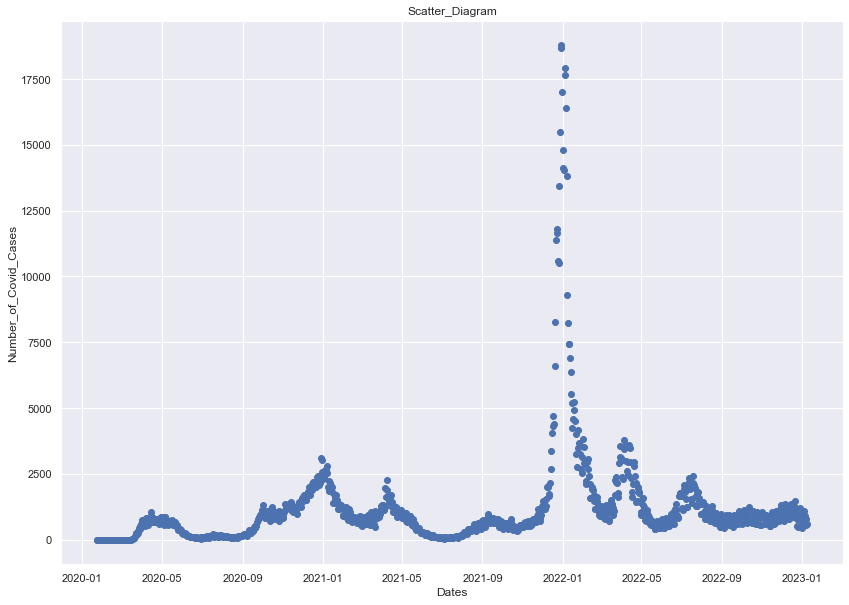

In [ ]:
#plot_dataset
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(x = df_3['Dates'], y= df_3['Number_of_Covid_Cases'])
plt.xlabel("Dates")
plt.ylabel("Number_of_Covid_Cases")
plt.title('Scatter_Diagram')

plt.show()


In [ ]:
#cutoff
cutoff_point = pd.to_datetime('2020/12/25')
outcome_group = df_3[df_3.Dates < cutoff_point].iloc[-50:,:] #chosen at 50 days
treatment_group = df_3[df_3.Dates >= cutoff_point].iloc[:50,:]

In [ ]:
#Statsmodel 
outcome_X = outcome_group.index
outcome_y = outcome_group.Number_of_Covid_Cases

outcome_X = sm.add_constant(outcome_X)

est = sm.OLS(outcome_y,outcome_X).fit()
est.summary()

print(est.summary())

                              OLS Regression Results                             
Dep. Variable:     Number_of_Covid_Cases   R-squared:                       0.780
Model:                               OLS   Adj. R-squared:                  0.775
Method:                    Least Squares   F-statistic:                     170.2
Date:                   Thu, 12 Jan 2023   Prob (F-statistic):           2.12e-17
Time:                           20:31:15   Log-Likelihood:                -329.38
No. Observations:                     50   AIC:                             662.8
Df Residuals:                         48   BIC:                             666.6
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5580.4410 

In [ ]:
treatment_X = treatment_group.index
treatment_y = treatment_group.Number_of_Covid_Cases

treatment_X = sm.add_constant(treatment_X)

model = sm.OLS(treatment_y,treatment_X).fit()
model.summary()

print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     Number_of_Covid_Cases   R-squared:                       0.824
Model:                               OLS   Adj. R-squared:                  0.820
Method:                    Least Squares   F-statistic:                     224.5
Date:                   Thu, 12 Jan 2023   Prob (F-statistic):           1.00e-19
Time:                           20:42:00   Log-Likelihood:                -350.35
No. Observations:                     50   AIC:                             704.7
Df Residuals:                         48   BIC:                             708.5
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.62e+04 

In [ ]:
outcome_X

array([[  1., 287.],
       [  1., 288.],
       [  1., 289.],
       [  1., 290.],
       [  1., 291.],
       [  1., 292.],
       [  1., 293.],
       [  1., 294.],
       [  1., 295.],
       [  1., 296.],
       [  1., 297.],
       [  1., 298.],
       [  1., 299.],
       [  1., 300.],
       [  1., 301.],
       [  1., 302.],
       [  1., 303.],
       [  1., 304.],
       [  1., 305.],
       [  1., 306.],
       [  1., 307.],
       [  1., 308.],
       [  1., 309.],
       [  1., 310.],
       [  1., 311.],
       [  1., 312.],
       [  1., 313.],
       [  1., 314.],
       [  1., 315.],
       [  1., 316.],
       [  1., 317.],
       [  1., 318.],
       [  1., 319.],
       [  1., 320.],
       [  1., 321.],
       [  1., 322.],
       [  1., 323.],
       [  1., 324.],
       [  1., 325.],
       [  1., 326.],
       [  1., 327.],
       [  1., 328.],
       [  1., 329.],
       [  1., 330.],
       [  1., 331.],
       [  1., 332.],
       [  1., 333.],
       [  1.,

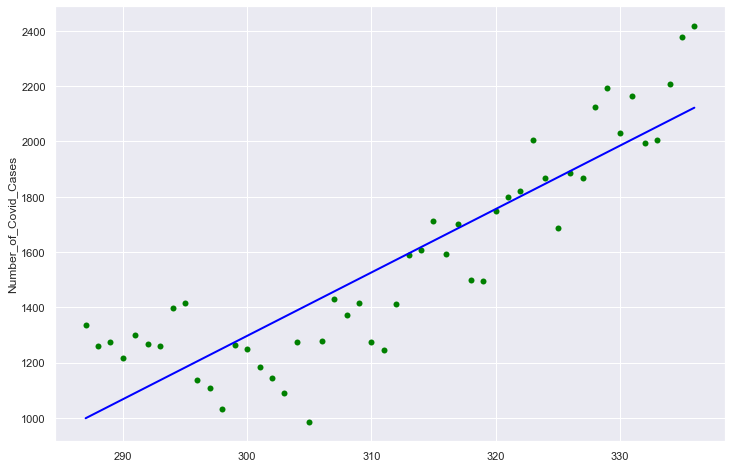

In [ ]:
#Plot dataset
plt.figure(figsize=(12,8))
ypred = est.predict(outcome_X)

sns.scatterplot(x = outcome_X[:,1], y = outcome_y,
            linewidth=0, color="green")
sns.lineplot(x = outcome_X[:,1], y = ypred, 
                linewidth=2, color="blue")

plt.show()

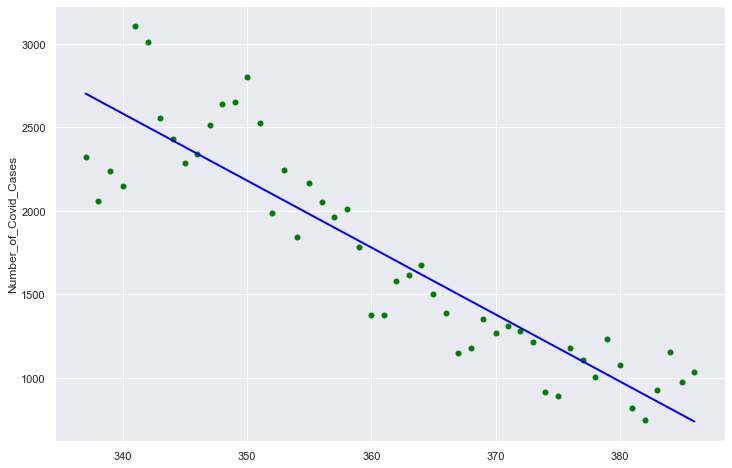

In [ ]:
plt.figure(figsize=(12,8))
ypred1 = model.predict(treatment_X)

sns.scatterplot(x = treatment_X[:,1], y = treatment_y,
            linewidth=0, color="green")
sns.lineplot(x = treatment_X[:,1], y = ypred1, 
                linewidth=2, color="blue")

plt.show()

In [ ]:
treatment_X

array([[  1., 337.],
       [  1., 338.],
       [  1., 339.],
       [  1., 340.],
       [  1., 341.],
       [  1., 342.],
       [  1., 343.],
       [  1., 344.],
       [  1., 345.],
       [  1., 346.],
       [  1., 347.],
       [  1., 348.],
       [  1., 349.],
       [  1., 350.],
       [  1., 351.],
       [  1., 352.],
       [  1., 353.],
       [  1., 354.],
       [  1., 355.],
       [  1., 356.],
       [  1., 357.],
       [  1., 358.],
       [  1., 359.],
       [  1., 360.],
       [  1., 361.],
       [  1., 362.],
       [  1., 363.],
       [  1., 364.],
       [  1., 365.],
       [  1., 366.],
       [  1., 367.],
       [  1., 368.],
       [  1., 369.],
       [  1., 370.],
       [  1., 371.],
       [  1., 372.],
       [  1., 373.],
       [  1., 374.],
       [  1., 375.],
       [  1., 376.],
       [  1., 377.],
       [  1., 378.],
       [  1., 379.],
       [  1., 380.],
       [  1., 381.],
       [  1., 382.],
       [  1., 383.],
       [  1.,

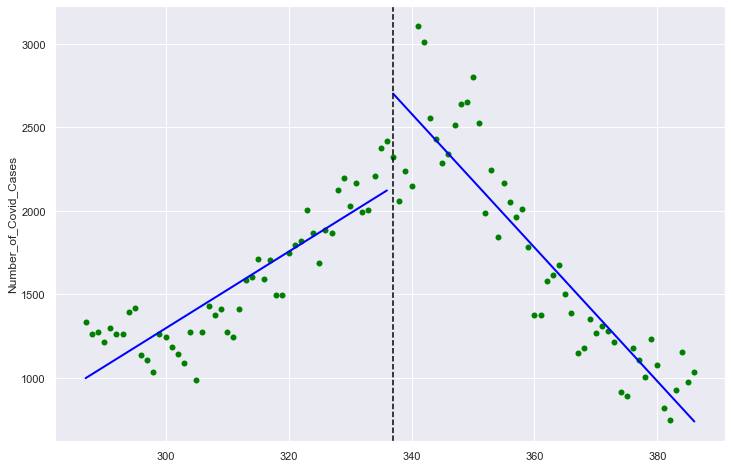

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = outcome_X[:,1], y = outcome_y,
            linewidth=0, color="green")
sns.lineplot(x = outcome_X[:,1], y = ypred, 
                linewidth=2, color="blue")

sns.scatterplot(x = treatment_X[:,1], y = treatment_y,
            linewidth=0, color="green")
sns.lineplot(x = treatment_X[:,1], y = ypred1, 
                linewidth=2, color="blue")

plt.axvline(337, c="black", ls="--", label="Christmas Lockdown")
plt.show()

### An interpretation of P-Value (the cutoff parameter)
•	According to the interpretation presented, the P-Value shows lower than 0.05, therefore this can successfully reject the null hypothesis, and it is statistically significant. 

### Justification on the design of the regression: 

•	By fitting the linear regression, at 50 days were considerably accurate to show how well the regression is progressing. 
As well, simple linear regression was used to explain my findings, and not polynomial degree. It was simpler to clarify my findings.

### 2 paragraph explanation of findings:

•	Based on several research, a temporary lockdown was authorized during the holiday Christmas break of 2020, any private gatherings were not permitted with members outside other than families and with people sharing the same household, which was to avoid an increase in cases. 
However, there was still a slight increase right after Christmas and then quickly escalated around New Year’s Eve. 

•	The regression shows a high estimate number of 3000 covid cases compared to few days prior. 
Following that event, Quebec announced a four-week extension of then temporary lockdown, therefore we can see that there’s a slight decrease but again quickly increases, during the month of January 2021. 
Near the end of the extended lockdown, covid cases were continuously decreases for the rest of the year. Therefore, the relationship between correlation and causation does not necessarily have to indicate an effect on the other. 